## Imports

In [2]:
!pip install keras_applications

     |████████████████████████████████| 50 kB 5.5 MB/s 


In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import random
from random import shuffle
import shutil
import math
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix
from tensorflow.keras.applications import * #Efficient Net included here
!pip install fast_ml
from fast_ml.model_development import train_valid_test_split
#from keras import Model

     |████████████████████████████████| 42 kB 916 kB/s 


Metrics imports

In [5]:
!pip install -U tensorflow-addons
import tensorflow as tf

from tensorflow.python.keras.metrics import Accuracy
from tensorflow.python.keras.metrics import CategoricalAccuracy
from tensorflow.python.keras.metrics import BinaryAccuracy
from tensorflow.python.keras.metrics import Recall
from tensorflow.python.keras.metrics import Precision
from tensorflow.python.keras.metrics import AUC
import tensorflow_addons as tfa

tf.math.confusion_matrix
tfa.metrics.F1Score

     |████████████████████████████████| 1.1 MB 13.3 MB/s 


tensorflow_addons.metrics.f_scores.F1Score

In [6]:
!pip install tf-explain
!pip install opencv-python

#tf-explain imports
from tf_explain.core.grad_cam import GradCAM
from tf_explain.callbacks.grad_cam import GradCAMCallback
from tensorflow.keras.utils import plot_model

     |████████████████████████████████| 43 kB 1.7 MB/s 


In [7]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Constants

In [ ]:
num_classes = 4
#dropout_rate = 0.2
input_shape = (299, 299, 3)

In [ ]:
catcount = {0: 26218, 1:8118, 2:6206, 3:18595}
num_classes = 4
total = sum(catcount.values())

weight_for_0 = 1/catcount[0]*(total / np.float(num_classes)) #total/(4.0*catcount_0)
weight_for_1 = 1/catcount[1]*(total / np.float(num_classes))
weight_for_2 = 1/catcount[2]*(total / np.float(num_classes))
weight_for_3 = 1/catcount[3]*(total / np.float(num_classes))

class_weights = {0:weight_for_0, 1:weight_for_1, 2:weight_for_2,3:weight_for_3}

print('Weight for class 0: {:.2f}'.format(class_weights[0]))
print('Weight for class 1: {:.2f}'.format(class_weights[1]))
print('Weight for class 2: {:.2f}'.format(class_weights[2]))
print('Weight for class 3: {:.2f}'.format(class_weights[3]))

Weight for class 0: 0.56
Weight for class 1: 1.82
Weight for class 2: 2.38
Weight for class 3: 0.80


## Helper functions

In [ ]:
# Helper functions
def print_loss_history(training_history, logscale=False):
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.show()
    return

def print_accuracy_history(training_history, logscale=False):
    acc = training_history['categorical_accuracy']
    val_acc = training_history['val_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color='red', label='Training acc')
    plt.plot(epochs, val_acc, color='green', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    if logscale:
      plt.yscale('log')
    plt.show()
    return

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='plasma')
            activation_index += 1   
    return

In [ ]:
# calculate a 6-number summary
from numpy import percentile
from numpy.random import rand

def six_number_summary(data):
  data = data
  # calculate quartiles
  quartiles = percentile(data, [25, 50, 75])
  # calculate min/max
  data_min, data_max, data_avg = np.min(data), np.max(data), np.average(data)
  # print 6-number summary
  return 'Avg: %.3f' % data_avg, 'Min: %.3f' % data_min, 'Q1: %.3f' % quartiles[0],'Median: %.3f' % quartiles[1], 'Q3: %.3f' % quartiles[2],'Max: %.3f' % data_max

  # print('Min: %.3f' % data_min)
  # print('Q1: %.3f' % quartiles[0])
  # print('Median: %.3f' % quartiles[1])
  # print('Q3: %.3f' % quartiles[2])
  # print('Max: %.3f' % data_max)


## Paths

In [ ]:
train_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train'
test_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test'
val_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val'

## Data generators

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=30, #went from 45 to 15 to 30 
    width_shift_range=0.2,  
    height_shift_range=0.2,    
    shear_range=0.2,        
    zoom_range=0.2,        
    horizontal_flip=True,         
    fill_mode='reflect',
    zca_whitening=True 
)
test_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(299,299), #changed from (256,256) for Xception
    color_mode='rgb',
    class_mode='categorical', #check this
    batch_size=32, #check this
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(299,299), #changed from (256,256) for Xception
    color_mode='rgb',
    #class_mode determines the type of label arrays that are returned
    class_mode='categorical',
    #class_mode='None'
    batch_size=1, 
    shuffle=False, 
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(299,299), #changed from (256,256) for Xception
    color_mode='rgb',
    class_mode='categorical', 
    batch_size=32, 
    shuffle=True, 
    seed=42
)

Found 59137 images belonging to 4 classes.
Found 12673 images belonging to 4 classes.
Found 12674 images belonging to 4 classes.


## Xception - architecture

In [ ]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.preprocessing import image

from keras.models import Model
from keras import layers
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.utils.layer_utils import get_source_inputs
#from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape
#from keras.applications.imagenet_utils import _obtain_input_shape


TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'


def Xception(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the Xception architecture.
    Optionally loads weights pre-trained
    on ImageNet. This model is available for TensorFlow only,
    and can only be used with inputs following the TensorFlow
    data format `(width, height, channels)`.
    You should set `image_data_format="channels_last"` in your Keras config
    located at ~/.keras/keras.json.
    Note that the default input image size for this model is 299x299.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)`.
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 71.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if K.backend() != 'tensorflow':
        raise RuntimeError('The Xception model is only available with '
                           'the TensorFlow backend.')
    if K.image_data_format() != 'channels_last':
        warnings.warn('The Xception model is only available for the '
                      'input data format "channels_last" '
                      '(width, height, channels). '
                      'However your settings specify the default '
                      'data format "channels_first" (channels, width, height). '
                      'You should set `image_data_format="channels_last"` in your Keras '
                      'config located at ~/.keras/keras.json. '
                      'The model being returned right now will expect inputs '
                      'to follow the "channels_last" data format.')
        K.set_image_data_format('channels_last')
        old_data_format = 'channels_first'
    else:
        old_data_format = None

    # #Determine proper input shape
    # print(f'The current value of input_shape is {input_shape}')
    # input_shape = _obtain_input_shape(input_shape,
    #                                   default_size=299,
    #                                   min_size=71,
    #                                   data_format=K.image_data_format())
    #                                   #include_top=include_top)
    # print(f'The current value of input_shape is {input_shape}')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)

    if include_top:
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    
    # Create model.
    model = Model(inputs, x, name='xception')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('xception_weights_tf_dim_ordering_tf_kernels.h5',
                                    TF_WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('xception_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    TF_WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)

    # if old_data_format:
    #     K.set_image_data_format(old_data_format)
    return model

## Xception - model definition

In [ ]:
X = Xception(include_top=True, weights=None,
             input_shape=(299, 299, 3),
             pooling=None,
             classes=num_classes)

In [ ]:
#X.summary()

In [8]:
initial_learning_rate=9e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=9200, #changed from 100k #9200
    decay_rate=0.90, #changed from 0.96 #0.96
    staircase=True
)

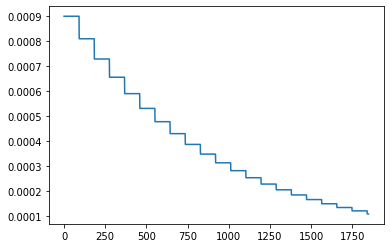

In [9]:
lr_list=[lr_schedule(x) for x in range(100 * (59137//32))]
plt.plot(lr_list[::100])

In [ ]:
X.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #logits=False due to softmax
          metrics=[tf.keras.metrics.CategoricalAccuracy()])  

## Xception - training

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Fourthbrain/Capstone/Checkpoints/'

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# train_generator.reset()
# val_generator.reset()

In [ ]:
X_history = X.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=1000,
    validation_data=val_generator,
    validation_freq=1,
    verbose=1,
    use_multiprocessing=True,
    workers=4,
    #class_weight=class_weights,#proportion of classes in training set 
    callbacks = [model_checkpoint_callback]
)

Epoch 1/1000
10/10 [==============================] - 1545s 167s/step - loss: 1.4159 - categorical_accuracy: 0.4531 - val_loss: 1.3712 - val_categorical_accuracy: 0.4433
Epoch 2/1000
10/10 [==============================] - 82s 7s/step - loss: 1.0294 - categorical_accuracy: 0.6406 - val_loss: 1.3708 - val_categorical_accuracy: 0.4433
Epoch 3/1000
10/10 [==============================] - 82s 7s/step - loss: 0.9644 - categorical_accuracy: 0.6562 - val_loss: 1.3744 - val_categorical_accuracy: 0.4433
Epoch 4/1000
10/10 [==============================] - 81s 7s/step - loss: 1.0451 - categorical_accuracy: 0.5969 - val_loss: 1.3758 - val_categorical_accuracy: 0.4433
Epoch 5/1000
10/10 [==============================] - 80s 7s/step - loss: 0.9320 - categorical_accuracy: 0.6938 - val_loss: 1.3771 - val_categorical_accuracy: 0.4433
Epoch 6/1000
10/10 [==============================] - 81s 7s/step - loss: 0.8316 - categorical_accuracy: 0.6969 - val_loss: 1.3789 - val_categorical_accuracy: 0.4433


In [ ]:
#X_history.history.keys()

## Xception - training charts

lr decay, **9e-4**, added callbacks, took out class_weights **(1000 epochs)**

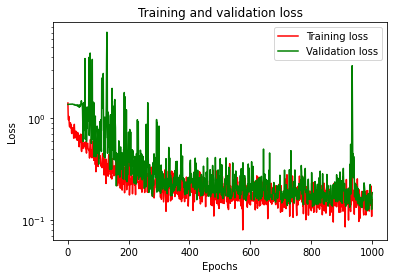

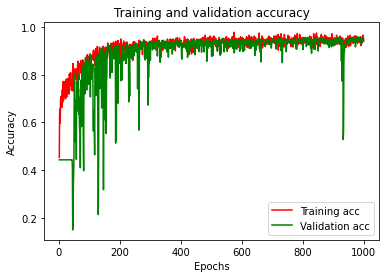

In [ ]:
print_loss_history(X_history.history, logscale=True)
print_accuracy_history(X_history.history, logscale=False)

In [ ]:
print(f"The six number summary for training loss is:\n {six_number_summary(X_history.history['loss'])}")
print(f"The six number summary for validation loss is:\n {six_number_summary(X_history.history['val_loss'])}")
print(f"The six number summary for training accuracy is:\n {six_number_summary(X_history.history['categorical_accuracy'])}")
print(f"The six number summary for validation accuracy is:\n {six_number_summary(X_history.history['val_categorical_accuracy'])}")

The six number summary for training loss is:
 ('Avg: 0.246', 'Min: 0.080', 'Q1: 0.164', 'Median: 0.201', 'Q3: 0.258', 'Max: 1.416')
The six number summary for validation loss is:
 ('Avg: 0.399', 'Min: 0.123', 'Q1: 0.182', 'Median: 0.220', 'Q3: 0.356', 'Max: 7.051')
The six number summary for training accuracy is:
 ('Avg: 0.917', 'Min: 0.453', 'Q1: 0.916', 'Median: 0.931', 'Q3: 0.947', 'Max: 0.978')
The six number summary for validation accuracy is:
 ('Avg: 0.879', 'Min: 0.150', 'Q1: 0.896', 'Median: 0.931', 'Q3: 0.941', 'Max: 0.958')


lr decay, **1e-4**, added callbacks, **took out class_weights** (300 epochs)

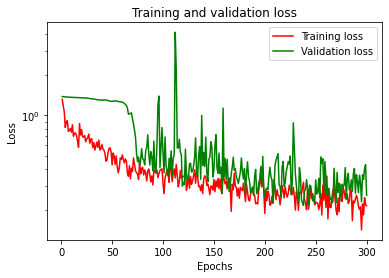

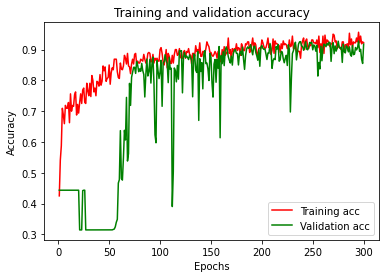

In [ ]:
print_loss_history(X_history.history, logscale=True)
print_accuracy_history(X_history.history, logscale=False)

In [ ]:
print(f"The six number summary for training loss is:\n {six_number_summary(X_history.history['loss'])}")
print(f"The six number summary for validation loss is:\n {six_number_summary(X_history.history['val_loss'])}")
print(f"The six number summary for training accuracy is:\n {six_number_summary(X_history.history['categorical_accuracy'])}")
print(f"The six number summary for validation accuracy is:\n {six_number_summary(X_history.history['val_categorical_accuracy'])}")

The six number summary for training loss is:
 ('Avg: 0.369', 'Min: 0.142', 'Q1: 0.260', 'Median: 0.311', 'Q3: 0.402', 'Max: 1.316')
The six number summary for validation loss is:
 ('Avg: 0.631', 'Min: 0.215', 'Q1: 0.322', 'Median: 0.420', 'Q3: 0.958', 'Max: 4.122')
The six number summary for training accuracy is:
 ('Avg: 0.870', 'Min: 0.425', 'Q1: 0.856', 'Median: 0.891', 'Q3: 0.916', 'Max: 0.956')
The six number summary for validation accuracy is:
 ('Avg: 0.757', 'Min: 0.314', 'Q1: 0.711', 'Median: 0.864', 'Q3: 0.897', 'Max: 0.928')


lr decay, **9.9e-4**, added callbacks (300 epochs)

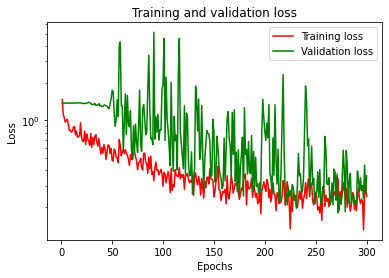

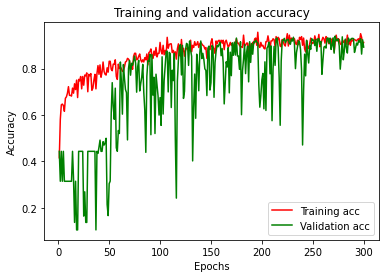

In [ ]:
print_loss_history(X_history.history, logscale=True)
print_accuracy_history(X_history.history, logscale=False)

In [ ]:
print(f"The six number summary for training loss is:\n {six_number_summary(X_history.history['loss'])}")
print(f"The six number summary for validation loss is:\n {six_number_summary(X_history.history['val_loss'])}")
print(f"The six number summary for training accuracy is:\n {six_number_summary(X_history.history['categorical_accuracy'])}")
print(f"The six number summary for validation accuracy is:\n {six_number_summary(X_history.history['val_categorical_accuracy'])}")

The six number summary for training loss is:
 ('Avg: 0.390', 'Min: 0.132', 'Q1: 0.254', 'Median: 0.319', 'Q3: 0.475', 'Max: 1.475')
The six number summary for validation loss is:
 ('Avg: 0.836', 'Min: 0.181', 'Q1: 0.344', 'Median: 0.634', 'Q3: 1.309', 'Max: 5.120')
The six number summary for training accuracy is:
 ('Avg: 0.865', 'Min: 0.416', 'Q1: 0.837', 'Median: 0.894', 'Q3: 0.916', 'Max: 0.956')
The six number summary for validation accuracy is:
 ('Avg: 0.735', 'Min: 0.105', 'Q1: 0.625', 'Median: 0.825', 'Q3: 0.898', 'Max: 0.940')


lr decay, 9e-4 (500 epochs)

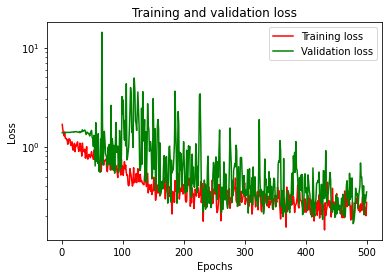

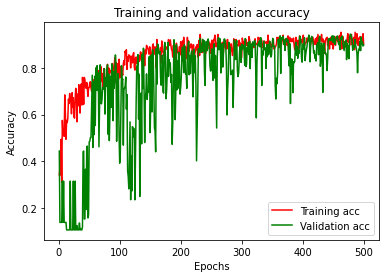

In [ ]:
print_loss_history(X_history.history, logscale=True)
print_accuracy_history(X_history.history, logscale=False)

In [ ]:
print(f"The six number summary for training loss is:\n {six_number_summary(X_history.history['loss'])}")
print(f"The six number summary for validation loss is:\n {six_number_summary(X_history.history['val_loss'])}")
print(f"The six number summary for training accuracy is:\n {six_number_summary(X_history.history['categorical_accuracy'])}")
print(f"The six number summary for validation accuracy is:\n {six_number_summary(X_history.history['val_categorical_accuracy'])}")

The six number summary for training loss is:
 ('Avg: 0.431', 'Min: 0.145', 'Q1: 0.270', 'Median: 0.335', 'Q3: 0.491', 'Max: 1.679')
The six number summary for validation loss is:
 ('Avg: 0.803', 'Min: 0.167', 'Q1: 0.323', 'Median: 0.528', 'Q3: 1.019', 'Max: 14.282')
The six number summary for training accuracy is:
 ('Avg: 0.854', 'Min: 0.309', 'Q1: 0.837', 'Median: 0.892', 'Q3: 0.913', 'Max: 0.953')
The six number summary for validation accuracy is:
 ('Avg: 0.740', 'Min: 0.105', 'Q1: 0.699', 'Median: 0.836', 'Q3: 0.898', 'Max: 0.945')


lr decay starting at **1.5e-3**, minor aug change **(300 epochs)**

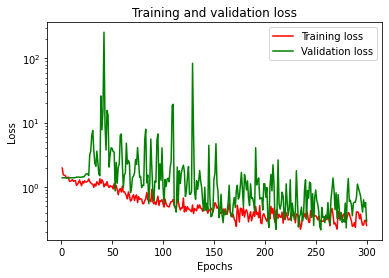

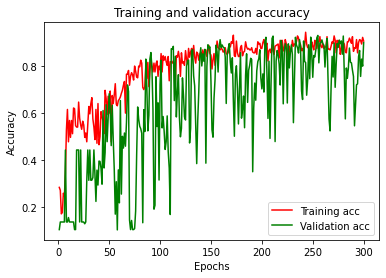

In [ ]:
print_loss_history(X_history.history, logscale=True)
print_accuracy_history(X_history.history, logscale=False)

In [ ]:
print(f"The six number summary for training loss is:\n {six_number_summary(X_history.history['loss'])}")
print(f"The six number summary for validation loss is:\n {six_number_summary(X_history.history['val_loss'])}")
print(f"The six number summary for training accuracy is:\n {six_number_summary(X_history.history['categorical_accuracy'])}")
print(f"The six number summary for validation accuracy is:\n {six_number_summary(X_history.history['val_categorical_accuracy'])}")

The six number summary for training loss is:
 ('Avg: 0.581', 'Min: 0.220', 'Q1: 0.350', 'Median: 0.451', 'Q3: 0.662', 'Max: 1.965')
The six number summary for validation loss is:
 ('Avg: 2.822', 'Min: 0.215', 'Q1: 0.540', 'Median: 0.976', 'Q3: 1.535', 'Max: 253.823')
The six number summary for training accuracy is:
 ('Avg: 0.790', 'Min: 0.172', 'Q1: 0.749', 'Median: 0.852', 'Q3: 0.881', 'Max: 0.944')
The six number summary for validation accuracy is:
 ('Avg: 0.630', 'Min: 0.104', 'Q1: 0.477', 'Median: 0.706', 'Q3: 0.840', 'Max: 0.930')


lr decay starting at 1.5e-3, minor aug change (50 epochs)

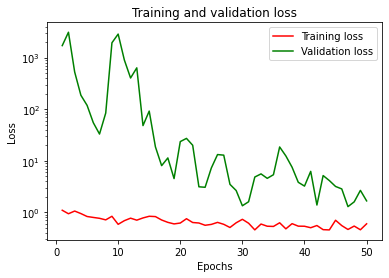

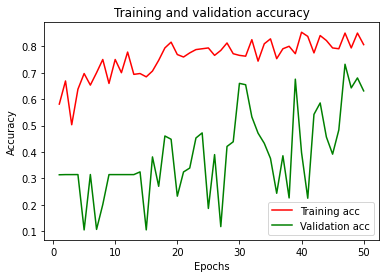

In [ ]:
print_loss_history(X_history.history, logscale=True)
print_accuracy_history(X_history.history, logscale=False)

In [ ]:
print(f"The six number summary for training loss is:\n {six_number_summary(X_history.history['loss'])}")
print(f"The six number summary for validation loss is:\n {six_number_summary(X_history.history['val_loss'])}")
print(f"The six number summary for training accuracy is:\n {six_number_summary(X_history.history['categorical_accuracy'])}")
print(f"The six number summary for validation accuracy is:\n {six_number_summary(X_history.history['val_categorical_accuracy'])}")

The six number summary for training loss is:
 ('Avg: 0.656', 'Min: 0.456', 'Q1: 0.544', 'Median: 0.620', 'Q3: 0.747', 'Max: 1.097')
The six number summary for validation loss is:
 ('Avg: 260.150', 'Min: 1.290', 'Q1: 3.294', 'Median: 7.775', 'Q3: 53.199', 'Max: 3120.784')
The six number summary for training accuracy is:
 ('Avg: 0.758', 'Min: 0.503', 'Q1: 0.716', 'Median: 0.773', 'Q3: 0.798', 'Max: 0.853')
The six number summary for validation accuracy is:
 ('Avg: 0.387', 'Min: 0.105', 'Q1: 0.314', 'Median: 0.378', 'Q3: 0.469', 'Max: 0.732')


## Xception - save/load models

lr decay, **9e-4**, added callbacks, took out class_weights **(1000 epochs)**

In [ ]:
#X.save('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_14')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_14/assets


In [ ]:
#Xception_model_14 = tf.keras.models.load_model('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_14')

lr decay, 1e-4, added callbacks, took out class_weights (300 epochs)

In [ ]:
#X.save('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_13')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_13/assets


In [ ]:
#Xception_model_13 = tf.keras.models.load_model('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_13')

lr decay, 9.9e-4, added callbacks (300 epochs)

In [ ]:
#X.save('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_12')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_12/assets


In [ ]:
#Xception_model_12 = tf.keras.models.load_model('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_12')

In [ ]:
#X.save('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_11')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_11/assets


In [ ]:
#Xception_model_11 = tf.keras.models.load_model('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_11')

In [ ]:
#X.save('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_10')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_10/assets


In [ ]:
#Xception_model_10 = tf.keras.models.load_model('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_10')

## Xception - inference

In [ ]:
xcheck_model = Xception_model_14.load_weights(checkpoint_filepath)

In [ ]:
#test_generator.reset()

In [ ]:
xcheck_model_preds = xcheck_model.predict(test_generator, verbose=True)

AttributeError: ignored

In [ ]:
Xception_model_14_preds = Xception_model_14.predict(test_generator, verbose=True)

12673/12673 [==============================] - 6176s 486ms/step


In [ ]:
print(Xception_model_14_preds.shape)
print(Xception_model_14_preds[0:5])

(12673, 4)
[[9.9894804e-01 1.6626483e-04 8.7993185e-04 5.8125502e-06]
 [9.9780744e-01 2.7059784e-04 1.9143947e-03 7.5337016e-06]
 [9.9624169e-01 8.4102585e-06 3.7495322e-03 3.3558425e-07]
 [9.9939322e-01 8.8941539e-05 5.1762786e-04 1.3218668e-07]
 [9.9984598e-01 1.5272481e-05 1.3860929e-04 7.6094189e-08]]


In [ ]:
os.chdir('/content/drive/MyDrive/Fourthbrain/Capstone/Predictions')
!pwd
!ls

/content/drive/MyDrive/Fourthbrain/Capstone/Predictions
predictions.npy  test.npy  X5pred.npy


In [ ]:
with open('X14pred.npy', 'wb') as f:
    np.save(f, Xception_model_14_preds)

In [ ]:
with open('X14pred.npy', 'rb') as f:
    Xception_model_14_preds = np.load(f)
print(Xception_model_14_preds[0:5])

[[9.9894804e-01 1.6626483e-04 8.7993185e-04 5.8125502e-06]
 [9.9780744e-01 2.7059784e-04 1.9143947e-03 7.5337016e-06]
 [9.9624169e-01 8.4102585e-06 3.7495322e-03 3.3558425e-07]
 [9.9939322e-01 8.8941539e-05 5.1762786e-04 1.3218668e-07]
 [9.9984598e-01 1.5272481e-05 1.3860929e-04 7.6094189e-08]]


In [ ]:
Xception14_preds_converted = (Xception_model_14_preds == Xception_model_14_preds.max(axis=1)[:,None]).astype(float)

In [ ]:
number_of_generator_calls = len(test_generator.filenames)
print(number_of_generator_calls)

12673


In [ ]:
test_labels = []
for i in range(0, number_of_generator_calls):
    test_labels.extend(np.array(test_generator[i][1]))

In [ ]:
test_labels_stacked = np.stack(test_labels)

In [ ]:
y_true = test_labels_stacked
y_pred = Xception14_preds_converted

In [ ]:
with open('predictions.npy', 'wb') as f:
    np.save(f, y_true)
    np.save(f, y_pred)

In [ ]:
with open('predictions.npy', 'rb') as f:
    y_true = np.load(f)
    y_pred = np.load(f)
print(y_true[-3:], y_pred[-3:])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      5618
           1       0.98      0.85      0.91      1740
           2       0.74      0.93      0.83      1330
           3       0.97      0.97      0.97      3985

   micro avg       0.94      0.94      0.94     12673
   macro avg       0.91      0.92      0.91     12673
weighted avg       0.94      0.94      0.94     12673
 samples avg       0.94      0.94      0.94     12673



## Xception - GradCAM

In [ ]:
CNV_IMG_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/CNV-53018-2.jpeg'
DME_IMG_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/DME-11053-1-X.jpeg'
DRUSEN_IMG_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/DRUSEN-53018-1.jpeg'
NORMAL_IMG_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/NORMAL-2567-3.jpeg'

In [ ]:
CNV_OUTPUT_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/CNV_ouptut/cnv.jpg'
DME_OUTPUT_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/DME_output/dme.jpg'
DRUSEN_OUTPUT_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/DRUSEN_output/drusen.jpg'
NORMAL_OUTPUT_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/NORMAL_output/normal.jpg'

In [ ]:
IMG_SIZE = (299, 299, 3)
IMG_DICT = {0:'CNV', 1:'DME', 2:'DRUSEN', 3:'NORMAL'}
IMG_PATH_LIST = [CNV_IMG_PATH, DME_IMG_PATH, DRUSEN_IMG_PATH, NORMAL_IMG_PATH]

In [ ]:
preprocess_input = keras.applications.xception.preprocess_input

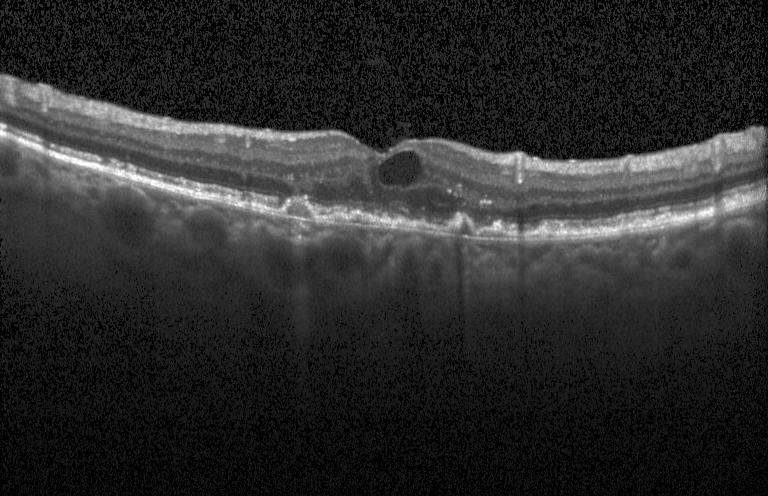

In [ ]:
# Displaying the CNV image
img_path = CNV_IMG_PATH
display(Image(img_path))

## GradCAM - functions

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    #add training=False to either above or below

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array, training=True) 
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

## GradCAM - model/predictions/output

In [ ]:
#INSERT SAVED MODEL HERE
# model.load_weights(checkpoint_filepath)
Xception_model_14.load_weights(checkpoint_filepath)
# Remove last layer's softmax
Xception_model_14.layers[-1].activation = None 

In [ ]:
# Define last convolution layer variable
last_conv_layer_name = Xception_model_14.layers[-3].name

In [ ]:
last_conv_layer_name

'block14_sepconv2_act'

[[  3.765171   -2.1025739   4.5474086 -11.169156 ]]
The model predicts that the image is: DRUSEN


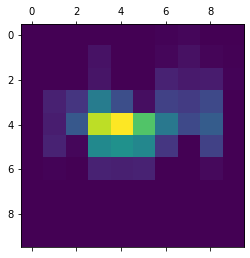

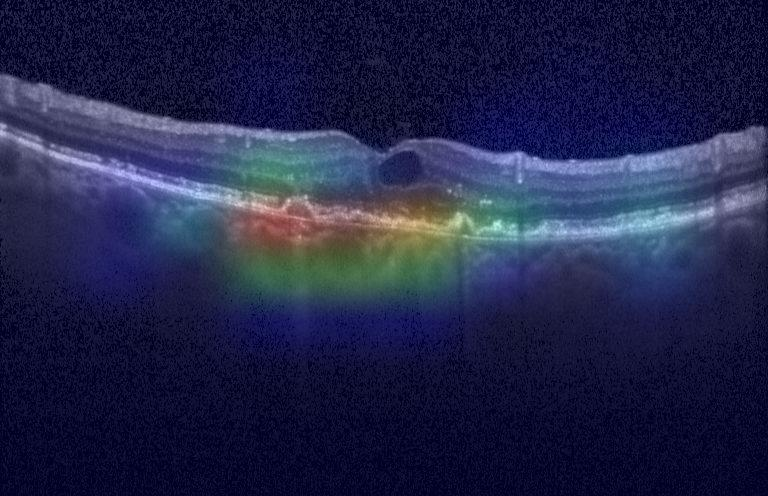

[[  3.693388   -1.9885486   4.531299  -11.072602 ]]
The model predicts that the image is: DRUSEN


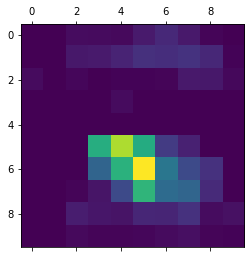

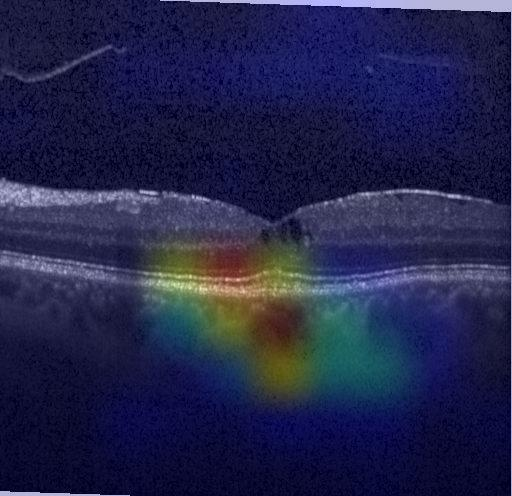

[[  3.6100106  -2.1761973   4.473766  -10.765361 ]]
The model predicts that the image is: DRUSEN


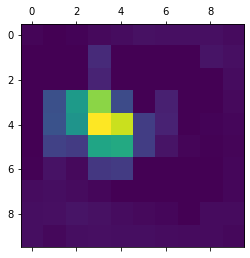

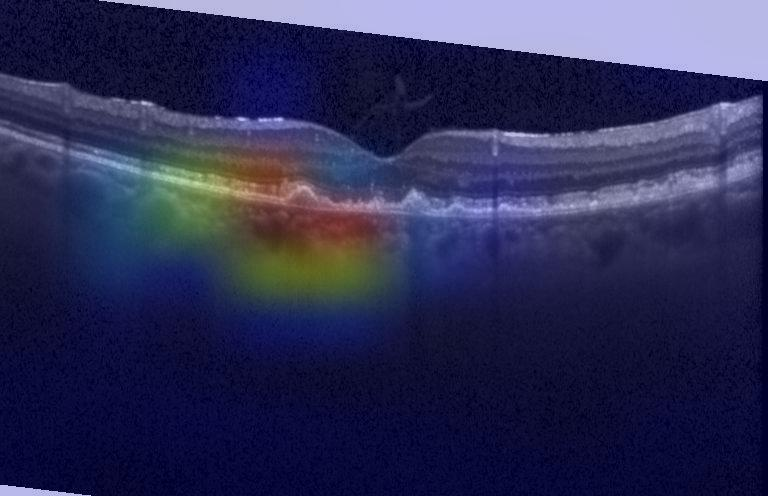

[[ 3.13869   -1.8322812  3.640093  -8.984804 ]]
The model predicts that the image is: DRUSEN


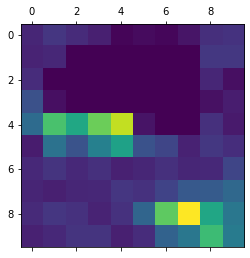

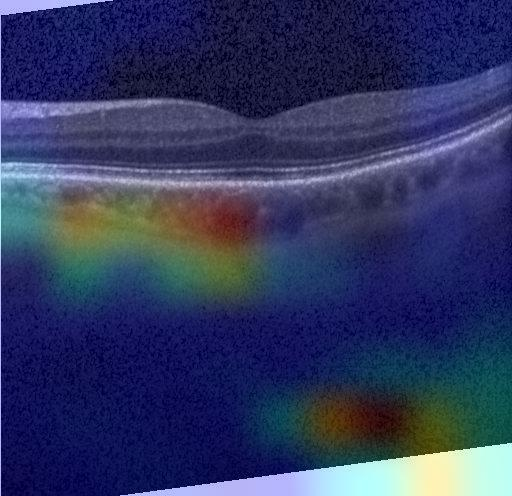

In [ ]:
for img_path in IMG_PATH_LIST:
  # Prepare image
  img_array = preprocess_input(get_img_array(img_path=img_path, size=IMG_SIZE))

  # Print predictions
  preds = Xception_model_14.predict(img_array) # <-- INSERT MODEL
  print(preds)
  preds_argmax = np.argmax(preds)

  if preds_argmax == 0:
    print(f'The model predicts that the image is: {IMG_DICT[0]}')
  elif preds_argmax == 1:
    print(f'The model predicts that the image is: {IMG_DICT[1]}')
  elif preds_argmax == 2:
    print(f'The model predicts that the image is: {IMG_DICT[2]}')
  elif preds_argmax == 3:
    print(f'The model predicts that the image is: {IMG_DICT[3]}')

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, Xception_model_14, last_conv_layer_name) # <-- INSERT MODEL

  # Display heatmap
  plt.matshow(heatmap)
  plt.show()

  if img_path == IMG_PATH_LIST[0]:
    cam_path = CNV_OUTPUT_PATH
  elif img_path == IMG_PATH_LIST[1]:
    cam_path = DME_OUTPUT_PATH
  elif img_path == IMG_PATH_LIST[2]:
    cam_path = DRUSEN_OUTPUT_PATH
  elif img_path == IMG_PATH_LIST[3]:
    cam_path = NORMAL_OUTPUT_PATH

  # Display heatmap layered on image
  # save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4)
  save_and_display_gradcam(img_path=img_path, heatmap=heatmap, cam_path=cam_path)

## Streamlit

In [ ]:
!pip install streamlit

In [ ]:
%%writefile /content/drive/MyDrive/Fourthbrain/Capstone/Streamlit/Leaky_ReLU.py
import streamlit as st
import tensorflow as tf
from tensorflow import keras

# MODEL_FILEPATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Xception with GradCAM.ipynb'
# import MODEL_FILEPATH
# from MODEL_FILEPATH import *

#Xception_model_13 = tf.keras.models.load_model('/content/drive/MyDrive/Fourthbrain/Capstone/Saved_models/Xception_model_13')

st.write("""
# Retinal Image Heatmaps
# This app shows how our model predicts retinal disorders!
""")

CNV_IMG_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/CNV-53018-2.jpeg'
DME_IMG_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/DME-11053-1-X.jpeg'
DRUSEN_IMG_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/DRUSEN-53018-1.jpeg'
NORMAL_IMG_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/NORMAL-2567-3.jpeg'

CNV_OUTPUT_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/CNV_ouptut/cnv.jpg'
DME_OUTPUT_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/DME_output/dme.jpg'
DRUSEN_OUTPUT_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/DRUSEN_output/drusen.jpg'
NORMAL_OUTPUT_PATH = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/GradCAM/NORMAL_output/normal.jpg'

st.subheader('CNV: Image & Heatmap overlay')
st.image([CNV_IMG_PATH, CNV_OUTPUT_PATH], caption=['CNV:Ground truth', 'CNV: Heatmap'], width=350)#, use_column_width=True)

st.subheader('DME: Image & Heatmap overlay')
st.image([DME_IMG_PATH, DME_OUTPUT_PATH], caption=['DME:Ground truth', 'DME: Heatmap'], width=350)#, use_column_width=True)

st.subheader('DRUSEN: Image & Heatmap overlay')
st.image([DRUSEN_IMG_PATH, DRUSEN_OUTPUT_PATH], caption=['DRUSEN:Ground truth', 'DRUSEN: Heatmap'], width=350)#, use_column_width=True)



Overwriting /content/drive/MyDrive/Fourthbrain/Capstone/Streamlit/Leaky_ReLU.py


In [ ]:
os.chdir('/content/drive/MyDrive/Fourthbrain/Capstone/Streamlit')

In [ ]:
!ls

 Leaky_ReLU.py			  ngrok-stable-linux-amd64.zip.4
 ngrok				  ngrok-stable-linux-amd64.zip.5
 ngrok-stable-linux-amd64.zip	  ngrok-stable-linux-amd64.zip.6
 ngrok-stable-linux-amd64.zip.1  'saved_Leaky_ReLU · Streamlit_files'
 ngrok-stable-linux-amd64.zip.2  'saved_Leaky_ReLU · Streamlit.html'
 ngrok-stable-linux-amd64.zip.3


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2021-11-18 18:52:06--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.9’

         ngrok-stab   0%[                    ]  95.11K   378KB/s               ^C


In [ ]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and then go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and then go to the following URL: https://cbbc-34-91-131-208.ngrok.io


In [ ]:
!streamlit run /content/drive/MyDrive/Fourthbrain/Capstone/Streamlit/Leaky_ReLU.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.91.131.208:8501

  Stopping...
  Stopping...


## **APPENDIX**

## Paths - creating 70/15/15 split

In [ ]:
# cnv_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/CNV/'
# dme_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/DME/'
# drusen_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/DRUSEN/'
# normal_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/NORMAL/'

In [ ]:
# cnv_list = os.listdir(cnv_path)
# dme_list = os.listdir(dme_path)
# drusen_list = os.listdir(drusen_path)
# normal_list = os.listdir(normal_path)

In [ ]:
# print(f'There are {len(cnv_list)} CNV images.')
# print(f'There are {len(dme_list)} DME images.')
# print(f'There are {len(drusen_list)} DRUSEN images.')
# print(f'There are {len(normal_list)} NORMAL images.')
# print(f'The total number of images is: {len(cnv_list)+len(dme_list)+len(drusen_list)+len(normal_list)}')

There are 37455 CNV images.
There are 11598 DME images.
There are 8866 DRUSEN images.
There are 26565 NORMAL images.
The total number of images is: 84484


In [ ]:
# print(cnv_list[0:5])
# print(dme_list[0:5])
# print(drusen_list[0:5])
# print(normal_list[0:5])

['CNV-9890872-5.jpeg', 'CNV-9911627-97.jpeg', 'CNV-9935363-11.jpeg', 'CNV-9911627-15.jpeg', 'CNV-9935363-118.jpeg']
['DME-9540117-1.jpeg', 'DME-9361825-21.jpeg', 'DME-910956-3.jpeg', 'DME-9504297-5.jpeg', 'DME-9361825-15.jpeg']
['DRUSEN-8986660-45.jpeg', 'DRUSEN-9000010-19.jpeg', 'DRUSEN-8986660-67.jpeg', 'DRUSEN-9049813-19.jpeg', 'DRUSEN-9072701-51.jpeg']
['NORMAL-9508165-7.jpeg', 'NORMAL-958613-1.jpeg', 'NORMAL-9523888-2.jpeg', 'NORMAL-9504920-4.jpeg', 'NORMAL-9501449-3.jpeg']


In [ ]:
# random.shuffle(cnv_list)
# random.shuffle(dme_list)
# random.shuffle(drusen_list)
# random.shuffle(normal_list)

In [ ]:
# print(cnv_list[0:5])
# print(dme_list[0:5])
# print(drusen_list[0:5])
# print(normal_list[0:5])

['CNV-3742373-7.jpeg', 'CNV-6566667-11.jpeg', 'CNV-7565927-32.jpeg', 'CNV-9174718-15.jpeg', 'CNV-6569286-116.jpeg']
['DME-4772167-5.jpeg', 'DME-4445075-40.jpeg', 'DME-462675-68.jpeg', 'DME-9915316-84.jpeg', 'DME-3358004-13.jpeg']
['DRUSEN-228939-40.jpeg', 'DRUSEN-2951435-6.jpeg', 'DRUSEN-7555604-13.jpeg', 'DRUSEN-1146923-15.jpeg', 'DRUSEN-8061223-4.jpeg']
['NORMAL-572972-3.jpeg', 'NORMAL-2628737-3.jpeg', 'NORMAL-6525579-6.jpeg', 'NORMAL-4417432-1.jpeg', 'NORMAL-3989090-5.jpeg']


In [ ]:
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train/cnv/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train/dme/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train/drusen/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train/normal/')

In [ ]:
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test/cnv/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test/dme/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test/drusen/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test/normal/')

In [ ]:
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val/cnv/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val/dme/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val/drusen/')
# os.mkdir('/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val/normal/')

In [ ]:
# train_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train/'
# test_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test/'
# val_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val/'

In [ ]:
# train_cnv_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train/cnv/'
# train_dme_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train/dme/'
# train_drusen_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train/drusen/'
# train_normal_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/train/normal/'

In [ ]:
# test_cnv_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test/cnv/'
# test_dme_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test/dme/'
# test_drusen_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test/drusen/'
# test_normal_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/test/normal/'

In [ ]:
# val_cnv_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val/cnv/'
# val_dme_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val/dme/'
# val_drusen_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val/drusen/'
# val_normal_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Classes/val/normal/'

In [ ]:
# def partition_pct(lst, point):
#     idx = int(len(lst) * point)
#     return lst[:idx], lst[idx:]

# l = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# l_70, l_30 = partition_pct(l, 0.7)
# l_15_1, l_15_2 = partition_pct(l_30, 0.5)

In [ ]:
# os.chdir(cnv_path)
# !pwd

/content/drive/MyDrive/Fourthbrain/Capstone/Classes/CNV


In [ ]:
# cnv_list_70, cnv_list_30 = partition_pct(cnv_list, .7)
# cnv_list_15_1, cnv_list_15_2 = partition_pct(cnv_list_30, .5)

# for (file_list, dirname) in ((cnv_list_70, train_cnv_path),
#                              (cnv_list_15_1, test_cnv_path),
#                              (cnv_list_15_2, val_cnv_path)):
#   for f in file_list:
#     shutil.move(f, dirname)

In [ ]:
# train_cnv_list = os.listdir(train_cnv_path)
# test_cnv_list = os.listdir(test_cnv_path)
# val_cnv_list = os.listdir(val_cnv_path)

In [ ]:
# print(f'There are {len(train_cnv_list)} files in train/cnv')
# print(f'There are {len(test_cnv_list)} files in test/cnv')
# print(f'There are {len(val_cnv_list)} files in val/cnv')
# print(f'There are {len(train_cnv_list)+len(test_cnv_list)+len(val_cnv_list)} total CNV files')

There are 26218 files in train/cnv
There are 5618 files in test/cnv
There are 5619 files in val/cnv
There are 37455 total CNV files


In [ ]:
# os.chdir(dme_path)
# !pwd

/content/drive/My Drive/Fourthbrain/Capstone/Classes/DME


In [ ]:
# dme_list_70, dme_list_30 = partition_pct(dme_list, .7)
# dme_list_15_1, dme_list_15_2 = partition_pct(dme_list_30, .5)

# for (file_list, dirname) in ((dme_list_70, train_dme_path),
#                              (dme_list_15_1, test_dme_path),
#                              (dme_list_15_2, val_dme_path)):
#   for f in file_list:
#     shutil.move(f, dirname)

In [ ]:
# train_dme_list = os.listdir(train_dme_path)
# test_dme_list = os.listdir(test_dme_path)
# val_dme_list = os.listdir(val_dme_path)

In [ ]:
# print(f'There are {len(train_dme_list)} files in train/dme')
# print(f'There are {len(test_dme_list)} files in test/dme')
# print(f'There are {len(val_dme_list)} files in val/dme')
# print(f'There are {len(train_dme_list)+len(test_dme_list)+len(val_dme_list)} total DME files')

There are 8118 files in train/dme
There are 1740 files in test/dme
There are 1740 files in val/dme
There are 11598 total DME files


In [ ]:
# os.chdir(drusen_path)
# !pwd

/content/drive/MyDrive/Fourthbrain/Capstone/Classes/DRUSEN


In [ ]:
# drusen_list_70, drusen_list_30 = partition_pct(drusen_list, .7)
# drusen_list_15_1, drusen_list_15_2 = partition_pct(drusen_list_30, .5)

# for (file_list, dirname) in ((drusen_list_70, train_drusen_path),
#                              (drusen_list_15_1, test_drusen_path),
#                              (drusen_list_15_2, val_drusen_path)):
#   for f in file_list:
#     shutil.move(f, dirname)

In [ ]:
# train_drusen_list = os.listdir(train_drusen_path)
# test_drusen_list = os.listdir(test_drusen_path)
# val_drusen_list = os.listdir(val_drusen_path)

In [ ]:
# print(f'There are {len(train_drusen_list)} files in train/drusen')
# print(f'There are {len(test_drusen_list)} files in test/drusen')
# print(f'There are {len(val_drusen_list)} files in val/drusen')
# print(f'There are {len(train_drusen_list)+len(test_drusen_list)+len(val_drusen_list)} total DRUSEN files')

There are 6206 files in train/drusen
There are 1330 files in test/drusen
There are 1330 files in val/drusen
There are 8866 total drusen files


In [ ]:
# os.chdir(normal_path)
# !pwd

/content/drive/MyDrive/Fourthbrain/Capstone/Classes/NORMAL


In [ ]:
# normal_list_70, normal_list_30 = partition_pct(normal_list, .7)
# normal_list_15_1, normal_list_15_2 = partition_pct(normal_list_30, .5)

# for (file_list, dirname) in ((normal_list_70, train_normal_path),
#                              (normal_list_15_1, test_normal_path),
#                              (normal_list_15_2, val_normal_path)):
#   for f in file_list:
#     shutil.move(f, dirname)

In [ ]:
# train_normal_list = os.listdir(train_normal_path)
# test_normal_list = os.listdir(test_normal_path)
# val_normal_list = os.listdir(val_normal_path)

In [ ]:
# print(f'There are {len(train_normal_list)} files in train/normal')
# print(f'There are {len(test_normal_list)} files in test/normal')
# print(f'There are {len(val_normal_list)} files in val/normal')
# print(f'There are {len(train_normal_list)+len(test_normal_list)+len(val_normal_list)} total NORMAL files')

There are 18595 files in train/normal
There are 3985 files in test/normal
There are 3985 files in val/normal
There are 26565 total NORMAL files


Move next three cells to Appendix

In [ ]:
# for i in range(len(synonym_list)):
#     dest1 = '../data/mushrooms_with_seperates_synonms/'+synonym_list[i][0]+'/'
#     for j in range(len(synonym_list[i])):
#         if (j != 0):
#             source = '../data/mushrooms_with_seperates_synonms/'+synonym_list[i][j]+'/'
#             files = os.listdir(source)
#             for k, f in enumerate(files):
#                 if not k % 10:
#                     shutil.move(source+f, dest1)

In [ ]:
# def split_three(lst, ratio=[0.8, 0.1, 0.1]):
#     import numpy as np

#     train_r, val_r, test_r = ratio
#     assert(np.sum(ratio) == 1.0)  # makes sure the splits make sense
#     # note we only need to give the first 2 indices to split, the last one it returns the rest of the list or empty
#     indicies_for_splitting = [int(len(lst) * train_r), int(len(lst) * (train_r+val_r))]
#     train, val, test = np.split(lst, indicies_for_splitting)
#     return train, val, test

In [ ]:
# X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'SalePrice', 
#                                                                             train_size=0.8, valid_size=0.1, test_size=0.1)

## Occlusion Sensitivity

In [ ]:
# Something to try later...

In [ ]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

In [ ]:
# https://github.com/sicara/tf-explain/blob/master/tf_explain/core/occlusion_sensitivity.py

# Instantiation of the explainer
explainer = OcclusionSensitivity()

# Args:
#     validation_data (Tuple[np.ndarray, Optional[np.ndarray]]): Validation data
#         to perform the method on. Tuple containing (x, y).
#     model (tf.keras.Model): tf.keras model to inspect
#     class_index (int): Index of targeted class
#     patch_size (int): Size of patch to apply on the image
#     colormap (int): OpenCV Colormap to use for heatmap visualization

output = explainer.explain(validation_data=val_generator, #Not sure it will accept generator
                           model=None, #INSERT MODEL HERE
                           class_index=IMG_DICT[0], # ???
                           )

# Save output
explainer.save(output, output_dir, output_name)